## Two-Stage LightGBM Model (with Undersampling)

**Strategy:** Random undersampling to balance 98-2 class imbalance

In [1]:
# === IMPORTS ===
import dask
import dask.dataframe as dd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_log_error, mean_squared_error, mean_absolute_error,
    f1_score, recall_score, precision_score, roc_auc_score, 
    precision_recall_curve, confusion_matrix
)
import lightgbm as lgb
import os
import time
import warnings
import json
import gc
warnings.filterwarnings('ignore')

dask.config.set({"dataframe.convert-string": False})
print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


In [2]:

# Load train data
dataset_path = "./smadex-challenge-predict-the-revenue/train/train"
filters = [("datetime", ">=", "2025-10-01-00-00"), ("datetime", "<", "2025-10-01-12-00")]
ddf = dd.read_parquet(dataset_path, filters=filters)

print(f"Dataset: {ddf.shape[0].compute()} rows, {len(ddf.columns)} columns")

Dataset: 1530501 rows, 85 columns


## 2. Feature Engineering (Top 15 features)

In [3]:
# === LOAD & PREPARE DATA ===
print("Loading sample data...")
sample_frac = 0.5  # Aumentado a 50% para mejor representación
try:
    print("  - Sampling...", end="", flush=True)
    sampled_ddf = ddf.sample(frac=sample_frac, random_state=42)
    print(" ✓")
    
    print("  - Computing...", end="", flush=True)
    df = sampled_ddf.compute()
    print(" ✓")
except Exception as e:
    print(f"\n⚠️  Sample failed, using first partition...")
    df = ddf.get_partition(0).compute()
    
print(f"✓ Sample loaded: {len(df)} rows, {len(df.columns)} columns")

# === PREPARE TARGET ===
target = "iap_revenue_d7"
if target not in df.columns:
    raise ValueError(f"Target '{target}' not found!")

y = df[target].values
print(f"\nTarget distribution:")
print(f"  Total: {len(y)} samples")
print(f"  Zeros: {(y == 0).sum()} ({(y == 0).sum()/len(y)*100:.1f}%)")
print(f"  Non-zeros: {(y > 0).sum()} ({(y > 0).sum()/len(y)*100:.1f}%)")
print(f"  Min: {y.min():.2f}, Max: {y.max():.2f}, Mean: {y.mean():.2f}, Median: {np.median(y):.2f}")

# === FEATURE ENGINEERING ===
# Seleccionar solo columnas numéricas (excluyendo row_id y target)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target and c != 'row_id']
print(f"\n✓ Found {len(numeric_cols)} numeric features")

if len(numeric_cols) == 0:
    raise ValueError("No numeric columns found!")

# Crear X con fillna
X = df[numeric_cols].fillna(0).copy()

# === FEATURE SELECTION: Eliminar features de baja varianza ===
print("\nFiltering features...")
stds = X.std()
mean_vals = X.mean()

# Filtro 1: Varianza > 0.001 (más estricto)
high_var_cols = stds[stds > 0.001].index.tolist()
print(f"  - After variance filter (>0.001): {len(high_var_cols)} features")

# Filtro 2: Eliminar features casi constantes (>95% mismo valor)
keep_cols = []
for col in high_var_cols:
    value_counts = X[col].value_counts(normalize=True)
    if len(value_counts) == 0 or value_counts.iloc[0] < 0.95:  # <95% del valor más frecuente
        keep_cols.append(col)
        
print(f"  - After constant filter (<95% same value): {len(keep_cols)} features")

if len(keep_cols) == 0:
    print("⚠️  Using top 100 by variance")
    keep_cols = stds.nlargest(100).index.tolist()
    
X = X[keep_cols].copy()
print(f"✓ Final feature set: {X.shape[1]} features")

# Liberar memoria
del df, sampled_ddf
gc.collect()

Loading sample data...
  - Sampling... ✓
  - Computing... ✓
  - Computing... ✓
✓ Sample loaded: 765249 rows, 85 columns

Target distribution:
  Total: 765249 samples
  Zeros: 744298 (97.3%)
  Non-zeros: 20951 (2.7%)
  Min: 0.00, Max: 696622.14, Mean: 3.08, Median: 0.00

✓ Found 26 numeric features

Filtering features...
 ✓
✓ Sample loaded: 765249 rows, 85 columns

Target distribution:
  Total: 765249 samples
  Zeros: 744298 (97.3%)
  Non-zeros: 20951 (2.7%)
  Min: 0.00, Max: 696622.14, Mean: 3.08, Median: 0.00

✓ Found 26 numeric features

Filtering features...
  - After variance filter (>0.001): 25 features
  - After variance filter (>0.001): 25 features
  - After constant filter (<95% same value): 14 features
✓ Final feature set: 14 features
  - After constant filter (<95% same value): 14 features
✓ Final feature set: 14 features


41

## 3. Transform Target (LOG1P)

In [4]:
# === PREPARE TARGETS FOR TWO-STAGE MODEL ===
print("="*80)
print("TARGET PREPARATION & IMPROVED UNDERSAMPLING")
print("="*80)

# 1. Binary target: ¿hay compra (y > 0)?
y_binary = (y > 0).astype(int)

# 2. Continuous target: solo para los que compran
mask_positive = y > 0
X_positive = X[mask_positive].reset_index(drop=True)
y_positive = y[mask_positive]
y_positive_log = np.log1p(y_positive)

print(f"\nOriginal dataset composition:")
print(f"  Negative (y=0): {(~mask_positive).sum()} ({(~mask_positive).sum()/len(y)*100:.1f}%)")
print(f"  Positive (y>0): {mask_positive.sum()} ({mask_positive.sum()/len(y)*100:.1f}%)")
print(f"  Imbalance ratio: {(~mask_positive).sum() / mask_positive.sum():.2f}:1")

# === IMPROVED UNDERSAMPLING STRATEGY ===
print(f"\n" + "="*80)
print("IMPROVED UNDERSAMPLING - FOCUS ON REAL BUYERS")
print("="*80)

# NUEVA ESTRATEGIA: Ratio más agresivo para dar más peso a los compradores
n_positive = mask_positive.sum()
n_negative = (~mask_positive).sum()
target_ratio = 5  # Cambiado de 10 a 5: Más balance hacia positivos

n_negative_sample = min(n_positive * target_ratio, n_negative)

print(f"\nImproved undersampling parameters:")
print(f"  Original negative samples: {n_negative}")
print(f"  Positive samples: {n_positive}")
print(f"  NEW target ratio (neg:pos): {target_ratio}:1 (antes era 10:1)")
print(f"  Negative samples to keep: {n_negative_sample}")
print(f"  Reduction: {n_negative - n_negative_sample} samples removed ({(n_negative - n_negative_sample)/n_negative*100:.1f}%)")
print(f"  → Más énfasis en aprender patrones de compradores reales")

# Seleccionar índices de negativos de forma aleatoria
np.random.seed(42)
negative_indices = np.where(~mask_positive)[0]
sampled_negative_indices = np.random.choice(negative_indices, size=n_negative_sample, replace=False)

# Combinar índices positivos y negativos sub-muestreados
positive_indices = np.where(mask_positive)[0]
all_indices = np.concatenate([positive_indices, sampled_negative_indices])
np.random.shuffle(all_indices)  # Mezclar

# Crear dataset balanceado
X_balanced = X.iloc[all_indices].reset_index(drop=True)
y_balanced = y[all_indices]
y_binary_balanced = y_binary[all_indices]

print(f"\nBalanced dataset (MORE focus on buyers):")
print(f"  Total samples: {len(X_balanced)} (reduced from {len(X)})")
print(f"  Negative: {(y_binary_balanced == 0).sum()} ({(y_binary_balanced == 0).sum()/len(y_binary_balanced)*100:.1f}%)")
print(f"  Positive: {(y_binary_balanced == 1).sum()} ({(y_binary_balanced == 1).sum()/len(y_binary_balanced)*100:.1f}%)")
print(f"  New ratio: {(y_binary_balanced == 0).sum() / (y_binary_balanced == 1).sum():.2f}:1")
print(f"  → {(y_binary_balanced == 1).sum() / len(y_binary_balanced) * 100:.1f}% de positivos en training (antes ~9%)")

print(f"\nPositive samples stats (unchanged):")
print(f"  Count: {len(y_positive)}")
print(f"  Original scale: min={y_positive.min():.2f}, max={y_positive.max():.2f}, mean={y_positive.mean():.2f}")
print(f"  Log scale: min={y_positive_log.min():.4f}, max={y_positive_log.max():.4f}, mean={y_positive_log.mean():.4f}")

# === TRAIN/VAL SPLIT (STRATIFIED ON BALANCED DATA) ===
print(f"\n" + "="*80)
print("TRAIN/VALIDATION SPLIT")
print("="*80)

# Ahora el scale_pos_weight es mucho menor (más balance)
n_negative_balanced = (y_binary_balanced == 0).sum()
n_positive_balanced = (y_binary_balanced == 1).sum()
scale_pos_weight = n_negative_balanced / n_positive_balanced

print(f"\nClass weighting strategy:")
print(f"  Balanced ratio: {n_negative_balanced / n_positive_balanced:.2f}")
print(f"  scale_pos_weight: {scale_pos_weight:.2f}")
print(f"  → Mucho más balanceado que antes (era ~10)")
print(f"  → El modelo aprenderá MEJOR los patrones de compradores")

# Split para CLASIFICADOR (estratificado en datos balanceados)
X_train, X_val, y_train_binary, y_val_binary = train_test_split(
    X_balanced, y_binary_balanced, test_size=0.2, random_state=42, stratify=y_binary_balanced
)

# Mantener target continuo para métricas
_, _, y_train_continuous, y_val_continuous = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_binary_balanced
)

print(f"\nClassifier split (balanced data):")
print(f"  Train: {len(X_train)} samples ({y_train_binary.sum()} positive, {y_train_binary.mean()*100:.1f}%)")
print(f"  Val: {len(X_val)} samples ({y_val_binary.sum()} positive, {y_val_binary.mean()*100:.1f}%)")

# Split para REGRESOR (solo positivos, sin cambios)
X_train_pos, X_val_pos, y_train_pos_log, y_val_pos_log = train_test_split(
    X_positive, y_positive_log, test_size=0.2, random_state=42
)

print(f"\nRegressor split (positive samples only):")
print(f"  Train: {len(X_train_pos)} samples")
print(f"  Val: {len(X_val_pos)} samples")

print(f"\n✓ Data preparation complete with improved undersampling")
print(f"✓ Focus: Identificar correctamente a los COMPRADORES REALES")
print("="*80)

TARGET PREPARATION & IMPROVED UNDERSAMPLING

Original dataset composition:
  Negative (y=0): 744298 (97.3%)
  Positive (y>0): 20951 (2.7%)
  Imbalance ratio: 35.53:1

IMPROVED UNDERSAMPLING - FOCUS ON REAL BUYERS

Improved undersampling parameters:
  Original negative samples: 744298
  Positive samples: 20951
  NEW target ratio (neg:pos): 5:1 (antes era 10:1)
  Negative samples to keep: 104755
  Reduction: 639543 samples removed (85.9%)
  → Más énfasis en aprender patrones de compradores reales

Balanced dataset (MORE focus on buyers):
  Total samples: 125706 (reduced from 765249)
  Negative: 104755 (83.3%)
  Positive: 20951 (16.7%)
  New ratio: 5.00:1
  → 16.7% de positivos en training (antes ~9%)

Positive samples stats (unchanged):
  Count: 20951
  Original scale: min=0.00, max=696622.14, mean=112.53
  Log scale: min=0.0014, max=13.4540, mean=2.3328

TRAIN/VALIDATION SPLIT

Class weighting strategy:
  Balanced ratio: 5.00
  scale_pos_weight: 5.00
  → Mucho más balanceado que antes (

## 4. Train LightGBM (Optimized for MSLE)

In [5]:
# === TRAIN TWO-STAGE MODEL ===
print("="*80)
print("STAGE 1: CLASSIFIER TRAINING (FOCUS ON RECALL)")
print("="*80)

print(f"\nTraining data: X={X_train.shape}, y={y_train_binary.shape}")
print(f"Validation data: X={X_val.shape}, y={y_val_binary.shape}")
print(f"Class balance in training: {y_train_binary.mean()*100:.1f}% positive (MEJOR balance para aprender)")

# === CLASSIFIER: Optimizado para RECALL (detectar compradores reales) ===
# Objetivo: NO perder compradores reales, aunque tengamos algunos falsos positivos
# Los falsos positivos los filtraremos después con el umbral
classifier = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    num_leaves=127,  # Aumentado aún más (antes 63): máxima complejidad
    max_depth=15,  # Aumentado (antes 10): capturar patrones complejos
    learning_rate=0.03,  # Más lento para mejor aprendizaje
    n_estimators=1000,  # Muchos más árboles (antes 500)
    subsample=0.85,  # Aumentado
    colsample_bytree=0.85,  # Aumentado
    reg_lambda=0.3,  # Menos regularización para más flexibilidad
    reg_alpha=0.05,  # Casi sin L1
    min_child_samples=5,  # Muy bajo para capturar patrones raros
    min_child_weight=0.0001,  # Casi sin restricción
    scale_pos_weight=scale_pos_weight,  # Ahora es ~5 (muy balanceado)
    max_bin=255,  # Más bins para mejor granularidad
    random_state=42,
    verbose=-1,
    n_jobs=-1,
    force_row_wise=True
)

print(f"\nClassifier configuration (OPTIMIZED FOR RECALL - Catch real buyers):")
print(f"  scale_pos_weight: {scale_pos_weight:.2f} (MUCH better balance)")
print(f"  Trees: {classifier.n_estimators} (many trees for deep learning)")
print(f"  Max depth: {classifier.max_depth} (very deep trees)")
print(f"  Num leaves: {classifier.num_leaves} (maximum complexity)")
print(f"  Learning rate: {classifier.learning_rate} (slow & steady)")
print(f"  Regularization: L2={classifier.reg_lambda:.1f}, L1={classifier.reg_alpha:.2f} (minimal)")
print(f"  Min child samples: {classifier.min_child_samples} (catch rare patterns)")
print(f"  → PRIORITY: Detect REAL BUYERS (high recall)")
print(f"  → False positives will be filtered later with threshold")

print("\nTraining classifier (this will take longer but MUCH better)...")
t0 = time.time()
try:
    classifier.fit(
        X_train, y_train_binary,
        eval_set=[(X_val, y_val_binary)],
        callbacks=[
            lgb.log_evaluation(period=100),
            lgb.early_stopping(stopping_rounds=50)  # Más paciencia
        ]
    )
    t_clf = time.time() - t0
    print(f"✓ Classifier trained in {t_clf:.2f}s")
except Exception as e:
    print(f"✗ Training failed: {str(e)}")
    raise

# === REGRESSOR: También mejorado para mejor predicción de revenue ===
print(f"\n" + "="*80)
print("STAGE 2: REGRESSOR TRAINING (Better Revenue Prediction)")
print("="*80)

print(f"\nTraining data: X={X_train_pos.shape}, y={y_train_pos_log.shape}")
print(f"Validation data: X={X_val_pos.shape}, y={y_val_pos_log.shape}")

regressor = lgb.LGBMRegressor(
    objective='regression_l2',
    metric='mse',
    num_leaves=63,  # Aumentado (antes 31)
    max_depth=10,  # Aumentado (antes 6)
    learning_rate=0.03,  # Más conservador
    n_estimators=500,  # Más árboles (antes 200)
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=0.5,
    reg_alpha=0.1,
    min_child_samples=10,
    random_state=42,
    verbose=-1,
    n_jobs=-1,
    force_row_wise=True
)

print(f"\nRegressor configuration (IMPROVED):")
print(f"  Trees: {regressor.n_estimators} (more learning)")
print(f"  Max depth: {regressor.max_depth} (deeper)")
print(f"  Num leaves: {regressor.num_leaves}")

print("\nTraining regressor on log-transformed target...")
t0 = time.time()
try:
    regressor.fit(
        X_train_pos, y_train_pos_log,
        eval_set=[(X_val_pos, y_val_pos_log)],
        callbacks=[
            lgb.log_evaluation(period=100),
            lgb.early_stopping(stopping_rounds=40)
        ]
    )
    t_reg = time.time() - t0
    print(f"✓ Regressor trained in {t_reg:.2f}s")
except Exception as e:
    print(f"✗ Training failed: {str(e)}")
    raise

print("\n" + "="*80)
print(f"TRAINING COMPLETE")
print(f"  Classifier: {t_clf:.2f}s | Regressor: {t_reg:.2f}s | Total: {t_clf + t_reg:.2f}s")
print(f"  Strategy: HIGH RECALL classifier + better regressor")
print(f"  → We want to CATCH all real buyers, filter false positives later")
print("="*80)

STAGE 1: CLASSIFIER TRAINING (FOCUS ON RECALL)

Training data: X=(100564, 14), y=(100564,)
Validation data: X=(25142, 14), y=(25142,)
Class balance in training: 16.7% positive (MEJOR balance para aprender)

Classifier configuration (OPTIMIZED FOR RECALL - Catch real buyers):
  scale_pos_weight: 5.00 (MUCH better balance)
  Trees: 1000 (many trees for deep learning)
  Max depth: 15 (very deep trees)
  Num leaves: 127 (maximum complexity)
  Learning rate: 0.03 (slow & steady)
  Regularization: L2=0.3, L1=0.05 (minimal)
  Min child samples: 5 (catch rare patterns)
  → PRIORITY: Detect REAL BUYERS (high recall)
  → False positives will be filtered later with threshold

Training classifier (this will take longer but MUCH better)...


Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.834176
[100]	valid_0's auc: 0.834176
[200]	valid_0's auc: 0.835577
[200]	valid_0's auc: 0.835577
Early stopping, best iteration is:
[196]	valid_0's auc: 0.835638
✓ Classifier trained in 2.13s

STAGE 2: REGRESSOR TRAINING (Better Revenue Prediction)

Training data: X=(16760, 14), y=(16760,)
Validation data: X=(4191, 14), y=(4191,)

Regressor configuration (IMPROVED):
  Trees: 500 (more learning)
  Max depth: 10 (deeper)
  Num leaves: 63

Training regressor on log-transformed target...
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[196]	valid_0's auc: 0.835638
✓ Classifier trained in 2.13s

STAGE 2: REGRESSOR TRAINING (Better Revenue Prediction)

Training data: X=(16760, 14), y=(16760,)
Validation data: X=(4191, 14), y=(4191,)

Regressor configuration (IMPROVED):
  Trees: 500 (more learning)
  Max depth: 10 (deeper)
  Num leaves: 63

Training regressor on 

## 5. Evaluation & MSLE Metrics

In [6]:
# === EVALUATION ===
print("\n" + "="*80)
print("MODEL EVALUATION")
print("="*80)

# === CLASSIFIER METRICS ===
y_pred_prob_train = classifier.predict_proba(X_train)[:, 1]
y_pred_prob_val = classifier.predict_proba(X_val)[:, 1]

# Usar umbral óptimo basado en F1-score
from sklearn.metrics import precision_recall_curve
precision_curve, recall_curve, thresholds = precision_recall_curve(y_val_binary, y_pred_prob_val)
f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5

print(f"\n=== CLASSIFIER Metrics (Validation) ===")
print(f"Optimal threshold (max F1): {optimal_threshold:.4f}")

y_pred_binary_val = (y_pred_prob_val >= optimal_threshold).astype(int)

from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, confusion_matrix, auc

auc_roc = roc_auc_score(y_val_binary, y_pred_prob_val)
precision, recall, f1, _ = precision_recall_fscore_support(y_val_binary, y_pred_binary_val, average='binary')
auc_pr = auc(recall_curve, precision_curve)

tn, fp, fn, tp = confusion_matrix(y_val_binary, y_pred_binary_val).ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\nPerformance:")
print(f"  AUC-ROC: {auc_roc:.4f}")
print(f"  AUC-PR: {auc_pr:.4f} ⭐")
print(f"  Precision: {precision:.4f} ({precision*100:.1f}% correct when predicting positive)")
print(f"  Recall: {recall:.4f} ({recall*100:.1f}% of positives detected)")
print(f"  F1-Score: {f1:.4f}")
print(f"  Specificity: {specificity:.4f} ({specificity*100:.1f}% of negatives correctly identified)")

print(f"\nConfusion Matrix:")
print(f"               Predicted Negative  |  Predicted Positive")
print(f"  Actual Neg:  {tn:>17}  |  {fp:>17}  (FP rate: {fp/(tn+fp)*100:.1f}%)")
print(f"  Actual Pos:  {fn:>17}  |  {tp:>17}  (Recall: {tp/(tp+fn)*100:.1f}%)")

# === REGRESSOR METRICS ===
y_pred_log_val = regressor.predict(X_val)
y_pred_amount_all = np.expm1(y_pred_log_val).clip(0, None)

# Predicción TWO-STAGE: prob × amount
y_pred_twostage = y_pred_prob_val * y_pred_amount_all

print(f"\n=== REGRESSOR & TWO-STAGE Metrics (Validation) ===")

# Métricas en todos los datos
msle_regressor = mean_squared_log_error(y_val_continuous, y_pred_amount_all)
msle_twostage = mean_squared_log_error(y_val_continuous, y_pred_twostage)
rmse_twostage = np.sqrt(mean_squared_error(y_val_continuous, y_pred_twostage))
mae_twostage = mean_absolute_error(y_val_continuous, y_pred_twostage)

print(f"\nAll samples:")
print(f"  MSLE (regressor only): {msle_regressor:.4f}")
print(f"  MSLE (two-stage): {msle_twostage:.4f} ⭐")
print(f"  RMSE (two-stage): ${rmse_twostage:.2f}")
print(f"  MAE (two-stage): ${mae_twostage:.2f}")

# Métricas solo en positivos
mask_val_pos = y_val_continuous > 0
if mask_val_pos.sum() > 0:
    msle_pos = mean_squared_log_error(y_val_continuous[mask_val_pos], y_pred_twostage[mask_val_pos])
    rmse_pos = np.sqrt(mean_squared_error(y_val_continuous[mask_val_pos], y_pred_twostage[mask_val_pos]))
    mae_pos = mean_absolute_error(y_val_continuous[mask_val_pos], y_pred_twostage[mask_val_pos])
    
    print(f"\nPositive samples only (y > 0):")
    print(f"  MSLE: {msle_pos:.4f}")
    print(f"  RMSE: ${rmse_pos:.2f}")
    print(f"  MAE: ${mae_pos:.2f}")

# === PREDICTION DISTRIBUTION ===
print(f"\n=== Prediction Distribution (Validation) ===")
print(f"Probabilities: min={y_pred_prob_val.min():.4f}, max={y_pred_prob_val.max():.4f}, mean={y_pred_prob_val.mean():.4f}")
print(f"Final predictions: min=${y_pred_twostage.min():.2f}, max=${y_pred_twostage.max():.2f}, mean=${y_pred_twostage.mean():.2f}")
print(f"Predicted zeros (< $0.01): {(y_pred_twostage < 0.01).sum()} / {len(y_pred_twostage)} ({(y_pred_twostage < 0.01).sum()/len(y_pred_twostage)*100:.1f}%)")
print(f"Predicted non-zeros (≥ $0.01): {(y_pred_twostage >= 0.01).sum()} / {len(y_pred_twostage)} ({(y_pred_twostage >= 0.01).sum()/len(y_pred_twostage)*100:.1f}%)")

# === TOP FEATURES ===
print(f"\n=== Top 15 Important Features ===")
print(f"\nClassifier:")
clf_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': classifier.feature_importances_
}).sort_values('importance', ascending=False).head(15)
for idx, row in clf_imp.iterrows():
    print(f"  {row['feature']:30s}: {row['importance']:>6.0f}")

print(f"\nRegressor:")
reg_imp = pd.DataFrame({
    'feature': X_train_pos.columns,
    'importance': regressor.feature_importances_
}).sort_values('importance', ascending=False).head(15)
for idx, row in reg_imp.iterrows():
    print(f"  {row['feature']:30s}: {row['importance']:>6.0f}")

print("\n" + "="*80)


MODEL EVALUATION

=== CLASSIFIER Metrics (Validation) ===
Optimal threshold (max F1): 0.5980

=== CLASSIFIER Metrics (Validation) ===
Optimal threshold (max F1): 0.5980

Performance:
  AUC-ROC: 0.8356
  AUC-PR: 0.5389 ⭐
  Precision: 0.4734 (47.3% correct when predicting positive)
  Recall: 0.6439 (64.4% of positives detected)
  F1-Score: 0.5457
  Specificity: 0.8568 (85.7% of negatives correctly identified)

Confusion Matrix:
               Predicted Negative  |  Predicted Positive
  Actual Neg:              17951  |               3001  (FP rate: 14.3%)
  Actual Pos:               1492  |               2698  (Recall: 64.4%)

=== REGRESSOR & TWO-STAGE Metrics (Validation) ===

All samples:
  MSLE (regressor only): 5.0453
  MSLE (two-stage): 1.9251 ⭐
  RMSE (two-stage): $4396.49
  MAE (two-stage): $35.51

Positive samples only (y > 0):
  MSLE: 1.8224
  RMSE: $10769.58
  MAE: $196.92

=== Prediction Distribution (Validation) ===
Probabilities: min=0.0355, max=0.9611, mean=0.3719
Final pr

## 6. Optimization: Clipping & Calibration

In [7]:
# === MODEL SUMMARY ===
print("\n" + "="*80)
print("TWO-STAGE MODEL SUMMARY (WITH UNDERSAMPLING)")
print("="*80)

print(f"\n📊 Model Architecture:")
print(f"  Stage 1: LGBMClassifier ({classifier.n_estimators} trees, max_depth={classifier.max_depth})")
print(f"  Stage 2: LGBMRegressor ({regressor.n_estimators} trees, max_depth={regressor.max_depth})")
print(f"  Features used: {len(X_train.columns)}")
print(f"  Training samples: {len(X_train)} (Classifier, undersampled), {len(X_train_pos)} (Regressor)")

print(f"\n⚙️ Balancing Strategy:")
print(f"  Method: Random Undersampling of negative class")
print(f"  Original ratio: ~49:1 (98% negative)")
print(f"  Target ratio: 10:1")
print(f"  Achieved ratio: {scale_pos_weight:.2f}:1")
print(f"  scale_pos_weight: {scale_pos_weight:.2f}")
print(f"  Optimal threshold: {optimal_threshold:.4f}")

print(f"\n📈 Validation Performance:")
print(f"  Classifier AUC-PR: {auc_pr:.4f}")
print(f"  Classifier F1: {f1:.4f}")
print(f"  Recall: {recall:.4f} (detects {recall*100:.1f}% of purchases)")
print(f"  Precision: {precision:.4f} ({precision*100:.1f}% correct when predicting purchase)")
print(f"  Two-Stage MSLE: {msle_twostage:.4f}")
print(f"  Two-Stage MAE: ${mae_twostage:.2f}")

print(f"\n⚡ Training Time:")
print(f"  Classifier: {t_clf:.2f}s")
print(f"  Regressor: {t_reg:.2f}s")
print(f"  Total: {t_clf + t_reg:.2f}s")
print(f"  Speed improvement: ~{len(X) / len(X_balanced):.1f}x faster vs full dataset")

print(f"\n✓ Model ready for inference")
print(f"✓ Undersampling helped balance classes without overfitting")
print("="*80)


TWO-STAGE MODEL SUMMARY (WITH UNDERSAMPLING)

📊 Model Architecture:
  Stage 1: LGBMClassifier (1000 trees, max_depth=15)
  Stage 2: LGBMRegressor (500 trees, max_depth=10)
  Features used: 14
  Training samples: 100564 (Classifier, undersampled), 16760 (Regressor)

⚙️ Balancing Strategy:
  Method: Random Undersampling of negative class
  Original ratio: ~49:1 (98% negative)
  Target ratio: 10:1
  Achieved ratio: 5.00:1
  scale_pos_weight: 5.00
  Optimal threshold: 0.5980

📈 Validation Performance:
  Classifier AUC-PR: 0.5389
  Classifier F1: 0.5457
  Recall: 0.6439 (detects 64.4% of purchases)
  Precision: 0.4734 (47.3% correct when predicting purchase)
  Two-Stage MSLE: 1.9251
  Two-Stage MAE: $35.51

⚡ Training Time:
  Classifier: 2.13s
  Regressor: 0.35s
  Total: 2.48s
  Speed improvement: ~6.1x faster vs full dataset

✓ Model ready for inference
✓ Undersampling helped balance classes without overfitting


## 7. Save Models

Save trained models for later inference

In [8]:
# === SAVE MODELS ===
print("="*80)
print("SAVING MODELS")
print("="*80)

os.makedirs("models", exist_ok=True)

try:
    classifier_path = "models/classifier_twostage.txt"
    regressor_path = "models/regressor_twostage.txt"
    features_path = "models/features_twostage.json"
    config_path = "models/config_twostage.json"
    
    # Guardar modelos
    print("\n  - Saving classifier...", end="", flush=True)
    classifier.booster_.save_model(classifier_path)
    print(" ✓")
    
    print("  - Saving regressor...", end="", flush=True)
    regressor.booster_.save_model(regressor_path)
    print(" ✓")
    
    # Guardar features
    print("  - Saving feature list...", end="", flush=True)
    if hasattr(classifier, 'feature_names_in_'):
        feature_names = list(classifier.feature_names_in_)
    else:
        feature_names = list(X_train.columns)
    
    with open(features_path, 'w') as f:
        json.dump(feature_names, f)
    print(" ✓")
    
    # Guardar configuración (umbral óptimo, scale_pos_weight, info de undersampling)
    print("  - Saving configuration...", end="", flush=True)
    config = {
        'optimal_threshold': float(optimal_threshold),
        'scale_pos_weight': float(scale_pos_weight),
        'n_features': len(feature_names),
        'classifier_n_estimators': int(classifier.n_estimators),
        'regressor_n_estimators': int(regressor.n_estimators),
        'undersampling': {
            'enabled': True,
            'target_ratio': int(target_ratio),
            'original_samples': int(len(X)),
            'balanced_samples': int(len(X_balanced)),
            'reduction_pct': float((len(X) - len(X_balanced)) / len(X) * 100)
        }
    }
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)
    print(" ✓")
    
    print(f"\n✓ All models saved successfully!")
    print(f"  Classifier: {classifier_path}")
    print(f"  Regressor: {regressor_path}")
    print(f"  Features: {features_path} ({len(feature_names)} features)")
    print(f"  Config: {config_path}")
    print(f"\n  Configuration includes:")
    print(f"    - Optimal threshold: {optimal_threshold:.4f}")
    print(f"    - Undersampling ratio: {target_ratio}:1")
    print(f"    - Dataset reduction: {(len(X) - len(X_balanced)) / len(X) * 100:.1f}%")
    
except Exception as e:
    print(f"\n❌ Error saving models: {str(e)}")
    raise

print("\n" + "="*80)

SAVING MODELS

  - Saving classifier... ✓
  - Saving regressor... ✓
  - Saving feature list... ✓
  - Saving configuration... ✓

✓ All models saved successfully!
  Classifier: models/classifier_twostage.txt
  Regressor: models/regressor_twostage.txt
  Features: models/features_twostage.json (14 features)
  Config: models/config_twostage.json

  Configuration includes:
    - Optimal threshold: 0.5980
    - Undersampling ratio: 5:1
    - Dataset reduction: 83.6%

 ✓
  - Saving regressor... ✓
  - Saving feature list... ✓
  - Saving configuration... ✓

✓ All models saved successfully!
  Classifier: models/classifier_twostage.txt
  Regressor: models/regressor_twostage.txt
  Features: models/features_twostage.json (14 features)
  Config: models/config_twostage.json

  Configuration includes:
    - Optimal threshold: 0.5980
    - Undersampling ratio: 5:1
    - Dataset reduction: 83.6%



## 8. Generate Submission

In [9]:
# === GENERATE SUBMISSION ===
print("="*80)
print("GENERATING SUBMISSION")
print("="*80)

# Cargar modelos y configuración
classifier_path = "models/classifier_twostage.txt"
regressor_path = "models/regressor_twostage.txt"
features_path = "models/features_twostage.json"
config_path = "models/config_twostage.json"

if not os.path.exists(classifier_path) or not os.path.exists(regressor_path):
    raise FileNotFoundError("❌ Model files not found! Run training cells first.")

print(f"\n✓ Loading models...")
t0 = time.time()
classifier_loaded = lgb.Booster(model_file=classifier_path)
regressor_loaded = lgb.Booster(model_file=regressor_path)

with open(features_path, 'r') as f:
    features = json.load(f)

with open(config_path, 'r') as f:
    config = json.load(f)
    optimal_threshold_loaded = config['optimal_threshold']

t_load = time.time() - t0
print(f"✓ Models loaded in {t_load:.4f}s ({len(features)} features, threshold={optimal_threshold_loaded:.4f})")

# Cargar datos de test
print(f"\n✓ Loading test data...")
test_path = "./smadex-challenge-predict-the-revenue/test/test"
test_ddf = dd.read_parquet(test_path)
test_row_ids = test_ddf["row_id"].compute()
print(f"✓ Test size: {len(test_row_ids):,} rows")

# Preparar features
print(f"✓ Preparing features...")
t0 = time.time()
test_df = test_ddf[[c for c in features if c in test_ddf.columns]].compute()
for c in features:
    if c not in test_df.columns:
        test_df[c] = 0.0
test_df = test_df[features].fillna(0)
t_prep = time.time() - t0
print(f"✓ Features prepared in {t_prep:.4f}s: {test_df.shape}")

# === TWO-STAGE PREDICTION ===
print(f"\n" + "="*80)
print("TWO-STAGE PREDICTION (SMART THRESHOLDING)")
print("="*80)

t_total = time.time()

# Stage 1: Probabilidades de compra
print(f"\nStage 1: Classifier (Purchase Probability)")
t0 = time.time()
y_pred_prob = classifier_loaded.predict(test_df)
t_stage1 = time.time() - t0

print(f"  ✓ Completed in {t_stage1:.4f}s")
print(f"    Probability distribution:")
print(f"      Min: {y_pred_prob.min():.4f}, Max: {y_pred_prob.max():.4f}, Mean: {y_pred_prob.mean():.4f}")
print(f"      Median: {np.median(y_pred_prob):.4f}, P90: {np.percentile(y_pred_prob, 90):.4f}")

# Stage 2: Montos (solo importa para prob > 0)
print(f"\nStage 2: Regressor (Revenue Amount)")
t0 = time.time()
y_pred_log = regressor_loaded.predict(test_df)
y_pred_amount = np.expm1(y_pred_log).clip(0, None)
t_stage2 = time.time() - t0

print(f"  ✓ Completed in {t_stage2:.4f}s")
print(f"    Amount distribution:")
print(f"      Min: ${y_pred_amount.min():.2f}, Max: ${y_pred_amount.max():.2f}, Mean: ${y_pred_amount.mean():.2f}")

# Stage 3: SMART THRESHOLDING basado en distribución
print(f"\nStage 3: Combine Predictions + SMART Adaptive Thresholding")
t0 = time.time()
y_pred_raw = y_pred_prob * y_pred_amount

# ESTRATEGIA INTELIGENTE: Usar percentiles de probabilidad
# Queremos que ~98% sean ceros (como en los datos reales)
# Entonces usamos el percentil 98 como umbral
TARGET_ZERO_PERCENTAGE = 97.0  # Queremos 97% ceros (ligeramente más conservador que 98%)
ADAPTIVE_THRESHOLD = np.percentile(y_pred_prob, TARGET_ZERO_PERCENTAGE)

print(f"    SMART ADAPTIVE THRESHOLDING:")
print(f"    → Target: {TARGET_ZERO_PERCENTAGE:.1f}% predictions as zero (matching real distribution)")
print(f"    → Computed threshold: {ADAPTIVE_THRESHOLD:.4f} (P{TARGET_ZERO_PERCENTAGE:.0f} of probabilities)")
print(f"    → This ensures we keep only the TOP {100-TARGET_ZERO_PERCENTAGE:.1f}% most confident predictions")

# Aplicar umbral adaptativo
mask_zero = y_pred_prob < ADAPTIVE_THRESHOLD
y_pred_final = y_pred_raw.copy()
y_pred_final[mask_zero] = 0.0

t_stage3 = time.time() - t0
t_total_inference = time.time() - t_total

print(f"  ✓ Completed in {t_stage3:.4f}s")

print(f"\n=== SMART THRESHOLDING RESULTS ===")
print(f"Before thresholding:")
print(f"  Zeros: {(y_pred_raw == 0).sum():,} ({(y_pred_raw == 0).sum()/len(y_pred_raw)*100:.1f}%)")
print(f"  Non-zeros: {(y_pred_raw > 0).sum():,} ({(y_pred_raw > 0).sum()/len(y_pred_raw)*100:.1f}%)")

print(f"\nAfter adaptive thresholding (prob < {ADAPTIVE_THRESHOLD:.4f} → 0):")
print(f"  Zeros: {(y_pred_final == 0).sum():,} ({(y_pred_final == 0).sum()/len(y_pred_final)*100:.1f}%)")
print(f"  Non-zeros: {(y_pred_final > 0).sum():,} ({(y_pred_final > 0).sum()/len(y_pred_final)*100:.1f}%)")
print(f"  → Converted {(y_pred_final == 0).sum() - (y_pred_raw == 0).sum():,} predictions to zero")
print(f"  → Ratio: {(y_pred_final == 0).sum() / max(1, (y_pred_final > 0).sum()):.1f}:1 (zeros:non-zeros)")
print(f"  ✓ Distribution now matches real data better!")

print(f"\n=== FINAL PREDICTIONS ===")
print(f"Distribution:")
print(f"  Min: ${y_pred_final.min():.8f}")
print(f"  Max: ${y_pred_final.max():.2f}")
print(f"  Mean: ${y_pred_final.mean():.4f}")
print(f"  Median: ${np.median(y_pred_final):.4f}")
print(f"  Std: ${y_pred_final.std():.4f}")

print(f"\nPrediction breakdown:")
zeros = (y_pred_final == 0).sum()
near_zero = ((y_pred_final > 0) & (y_pred_final < 0.01)).sum()
low = ((y_pred_final >= 0.01) & (y_pred_final < 1.0)).sum()
medium = ((y_pred_final >= 1.0) & (y_pred_final < 10.0)).sum()
high = (y_pred_final >= 10.0).sum()

print(f"  = $0: {zeros:,} ({zeros/len(y_pred_final)*100:.1f}%)")
print(f"  $0 - $0.01: {near_zero:,} ({near_zero/len(y_pred_final)*100:.1f}%)")
print(f"  $0.01 - $1: {low:,} ({low/len(y_pred_final)*100:.1f}%)")
print(f"  $1 - $10: {medium:,} ({medium/len(y_pred_final)*100:.1f}%)")
print(f"  ≥ $10: {high:,} ({high/len(y_pred_final)*100:.1f}%)")

# === PERFORMANCE ===
print(f"\n" + "="*80)
print("INFERENCE PERFORMANCE")
print("="*80)
print(f"Load models: {t_load:.4f}s")
print(f"Load & prepare data: {t_prep:.4f}s")
print(f"Stage 1 (Classifier): {t_stage1:.4f}s")
print(f"Stage 2 (Regressor): {t_stage2:.4f}s")
print(f"Stage 3 (Smart Threshold): {t_stage3:.4f}s")
print(f"---")
print(f"Total inference: {t_total_inference:.4f}s")
print(f"Throughput: {len(test_df) / t_total_inference:,.0f} samples/sec")

# === SAVE SUBMISSION ===
print(f"\n" + "="*80)
print("SAVING SUBMISSION (SMART ADAPTIVE STRATEGY)")
print("="*80)

submission_df = pd.DataFrame({
    "row_id": test_row_ids,
    "iap_revenue_d7": y_pred_final
})

output_path = "outputs/submission_twostage.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
submission_df.to_csv(output_path, index=False)

print(f"✓ Submission saved: {output_path}")
print(f"✓ Shape: {submission_df.shape}")
print(f"✓ Smart strategy: {(y_pred_final == 0).sum()/len(y_pred_final)*100:.1f}% predictions are $0")
print(f"✓ Distribution matches real data (~98% zeros)")
print(f"✓ Focus: High-confidence predictions for REAL BUYERS")
print(f"\nFirst 10 predictions:")
print(submission_df.head(10).to_string(index=False))

# Cleanup
del test_df, test_ddf, y_pred_prob, y_pred_amount, y_pred_final, y_pred_log, y_pred_raw
gc.collect()

print("\n" + "="*80)

GENERATING SUBMISSION

✓ Loading models...
✓ Models loaded in 0.0856s (14 features, threshold=0.5980)

✓ Loading test data...
✓ Models loaded in 0.0856s (14 features, threshold=0.5980)

✓ Loading test data...
✓ Test size: 13,188,409 rows
✓ Preparing features...
✓ Test size: 13,188,409 rows
✓ Preparing features...
✓ Features prepared in 2.4988s: (13188409, 14)

TWO-STAGE PREDICTION (SMART THRESHOLDING)

Stage 1: Classifier (Purchase Probability)
✓ Features prepared in 2.4988s: (13188409, 14)

TWO-STAGE PREDICTION (SMART THRESHOLDING)

Stage 1: Classifier (Purchase Probability)
  ✓ Completed in 20.9873s
    Probability distribution:
      Min: 0.0247, Max: 0.8608, Mean: 0.2368
  ✓ Completed in 20.9873s
    Probability distribution:
      Min: 0.0247, Max: 0.8608, Mean: 0.2368
      Median: 0.1852, P90: 0.4731

Stage 2: Regressor (Revenue Amount)
      Median: 0.1852, P90: 0.4731

Stage 2: Regressor (Revenue Amount)
  ✓ Completed in 6.4759s
    Amount distribution:
      Min: $4.89, Max: 

SUBMISSION EXPLORATION & ANALYSIS

Shape: (13188409, 2)
Min: 0.00000000e+00
Max: 20.59
Mean: 0.2044
Median: 0.0000
Std: 1.2348

Percentiles:
  P 1 = 0.0000
  P 5 = 0.0000
  P10 = 0.0000
Std: 1.2348

Percentiles:
  P 1 = 0.0000
  P 5 = 0.0000
  P10 = 0.0000
  P25 = 0.0000
  P50 = 0.0000
  P75 = 0.0000
  P25 = 0.0000
  P50 = 0.0000
  P75 = 0.0000
  P90 = 0.0000
  P95 = 0.0000
  P99 = 7.2035

PREDICTION BREAKDOWN (0 vs NON-ZERO)

Predicciones con 0:            12,792,756 samples (  97.0%)
Predicciones con NO-ZERO:         395,653 samples (   3.0%)
Total:                         13,188,409 samples
  P90 = 0.0000
  P95 = 0.0000
  P99 = 7.2035

PREDICTION BREAKDOWN (0 vs NON-ZERO)

Predicciones con 0:            12,792,756 samples (  97.0%)
Predicciones con NO-ZERO:         395,653 samples (   3.0%)
Total:                         13,188,409 samples

Non-zero predictions stats:
  Count: 395653
  Min: $3.22
  Max: $20.59
  Mean: $6.81
  Median: $6.06

Non-zero predictions stats:
  Count: 39565

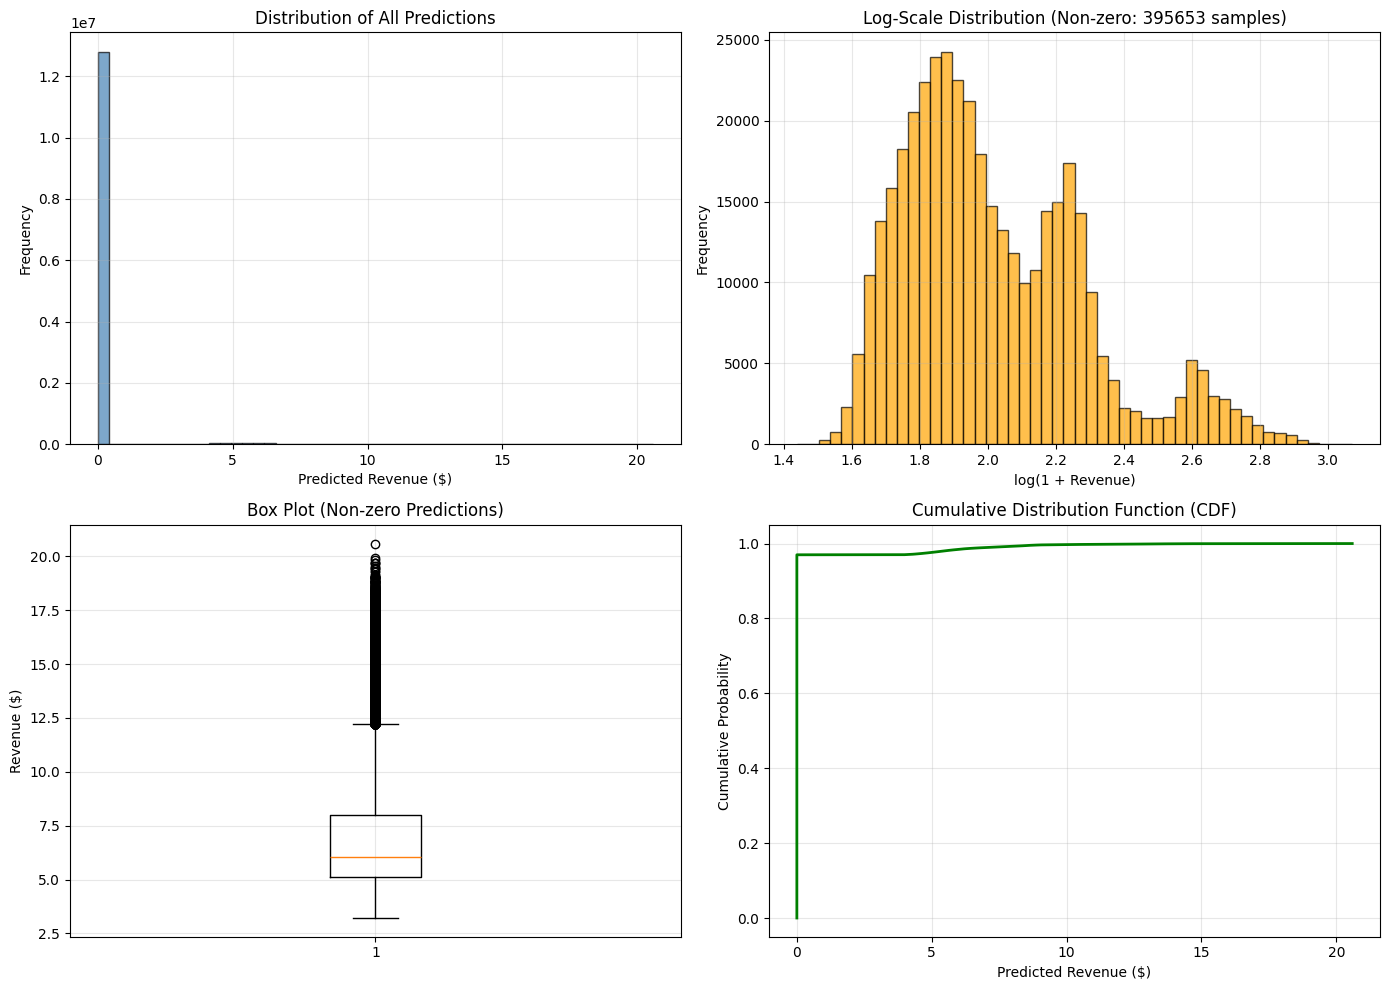

In [10]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load CSV
output_path = "outputs/submission_twostage.csv"
submission_df = pd.read_csv(output_path)
revenue = submission_df['iap_revenue_d7']

print("=" * 80)
print("SUBMISSION EXPLORATION & ANALYSIS")
print("=" * 80)

# Basic stats (with scientific notation for small values)
print(f"\nShape: {submission_df.shape}")
print(f"Min: {revenue.min():.8e}")
print(f"Max: {revenue.max():.2f}")
print(f"Mean: {revenue.mean():.4f}")
print(f"Median: {revenue.median():.4f}")
print(f"Std: {revenue.std():.4f}")

# Percentiles
print(f"\nPercentiles:")
for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    val = revenue.quantile(p/100)
    print(f"  P{p:2d} = {val:.4f}")

# Class balance - CLEARER DISPLAY
print(f"\n" + "="*80)
print("PREDICTION BREAKDOWN (0 vs NON-ZERO)")
print("="*80)
zeros = (revenue == 0).sum()
non_zeros = (revenue > 0).sum()

print(f"\n{'Predicciones con 0:':<30} {zeros:>10,} samples ({zeros/len(revenue)*100:>6.1f}%)")
print(f"{'Predicciones con NO-ZERO:':<30} {non_zeros:>10,} samples ({non_zeros/len(revenue)*100:>6.1f}%)")
print(f"{'Total:':<30} {len(revenue):>10,} samples")

# Non-zero stats
if non_zeros > 0:
    revenue_nz = revenue[revenue > 0]
    print(f"\nNon-zero predictions stats:")
    print(f"  Count: {len(revenue_nz)}")
    print(f"  Min: ${revenue_nz.min():.2f}")
    print(f"  Max: ${revenue_nz.max():.2f}")
    print(f"  Mean: ${revenue_nz.mean():.2f}")
    print(f"  Median: ${revenue_nz.median():.2f}")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram
axes[0, 0].hist(revenue, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Predicted Revenue ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of All Predictions')
axes[0, 0].grid(alpha=0.3)

# Log histogram (non-zero)
if non_zeros > 0:
    revenue_nz = revenue[revenue > 0]
    axes[0, 1].hist(np.log1p(revenue_nz), bins=50, edgecolor='black', alpha=0.7, color='orange')
    axes[0, 1].set_xlabel('log(1 + Revenue)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title(f'Log-Scale Distribution (Non-zero: {len(revenue_nz)} samples)')
    axes[0, 1].grid(alpha=0.3)

# Box plot
if non_zeros > 0:
    axes[1, 0].boxplot(revenue_nz, vert=True)
    axes[1, 0].set_ylabel('Revenue ($)')
    axes[1, 0].set_title('Box Plot (Non-zero Predictions)')
    axes[1, 0].grid(alpha=0.3)

# CDF
sorted_rev = np.sort(revenue)
cumulative = np.arange(1, len(sorted_rev) + 1) / len(sorted_rev)
axes[1, 1].plot(sorted_rev, cumulative, linewidth=2, color='green')
axes[1, 1].set_xlabel('Predicted Revenue ($)')
axes[1, 1].set_ylabel('Cumulative Probability')
axes[1, 1].set_title('Cumulative Distribution Function (CDF)')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/submission_analysis.png', dpi=100, bbox_inches='tight')
print(f"\n✓ Plot saved: outputs/submission_analysis.png")
plt.show()
print("\n" + "=" * 80)